# Deep Learning for System Identification
## Introduction: Least-squares estimation and simulation error minimization
## Cascaded tanks benchmark
### Author: Dario Piga, IDSIA SUPSI/USI, Lugano, Switzerland

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
%matplotlib widget 

### Load data from the [Cascaded Tanks benchmark](https://www.nonlinearbenchmark.org/benchmarks/cascaded-tanks)

In [2]:
dataset = pd.read_csv("../Datasets/CascadedTanks/dataBenchmark.csv") #change path according to the location of your csv file 
print(dataset)

print('\n Dataset info: \n')
print(dataset.info())

        uEst     uVal    yEst    yVal   Ts  Unnamed: 5
0     3.2567  0.97619  5.2050  4.9728  4.0         NaN
1     3.2466  0.99921  5.2154  4.9722  NaN         NaN
2     3.2309  1.01720  5.2215  4.9703  NaN         NaN
3     3.2097  1.03180  5.2142  4.9880  NaN         NaN
4     3.1836  1.04560  5.2001  4.9825  NaN         NaN
...      ...      ...     ...     ...  ...         ...
1019  3.2300  0.83275  3.6672  3.7881  NaN         NaN
1020  3.2451  0.85406  3.6379  3.7978  NaN         NaN
1021  3.2554  0.88351  3.6883  3.7807  NaN         NaN
1022  3.2610  0.91620  3.6831  3.7151  NaN         NaN
1023  3.2615  0.94805  3.6831  3.7179  NaN         NaN

[1024 rows x 6 columns]

 Dataset info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   uEst        1024 non-null   float64
 1   uVal        1024 non-null   float64
 2   yEst        1024 non-n

In [3]:
# rename the columns in training and test sequences (we typically call validation set the one used to tune algorithms' hyper-parameters)
dataset = dataset.rename(columns = {'uEst': 'u_train', 'uVal': 'u_test', 'yEst': 'y_train', 'yVal': 'y_test', })
print(dataset)

      u_train   u_test  y_train  y_test   Ts  Unnamed: 5
0      3.2567  0.97619   5.2050  4.9728  4.0         NaN
1      3.2466  0.99921   5.2154  4.9722  NaN         NaN
2      3.2309  1.01720   5.2215  4.9703  NaN         NaN
3      3.2097  1.03180   5.2142  4.9880  NaN         NaN
4      3.1836  1.04560   5.2001  4.9825  NaN         NaN
...       ...      ...      ...     ...  ...         ...
1019   3.2300  0.83275   3.6672  3.7881  NaN         NaN
1020   3.2451  0.85406   3.6379  3.7978  NaN         NaN
1021   3.2554  0.88351   3.6883  3.7807  NaN         NaN
1022   3.2610  0.91620   3.6831  3.7151  NaN         NaN
1023   3.2615  0.94805   3.6831  3.7179  NaN         NaN

[1024 rows x 6 columns]


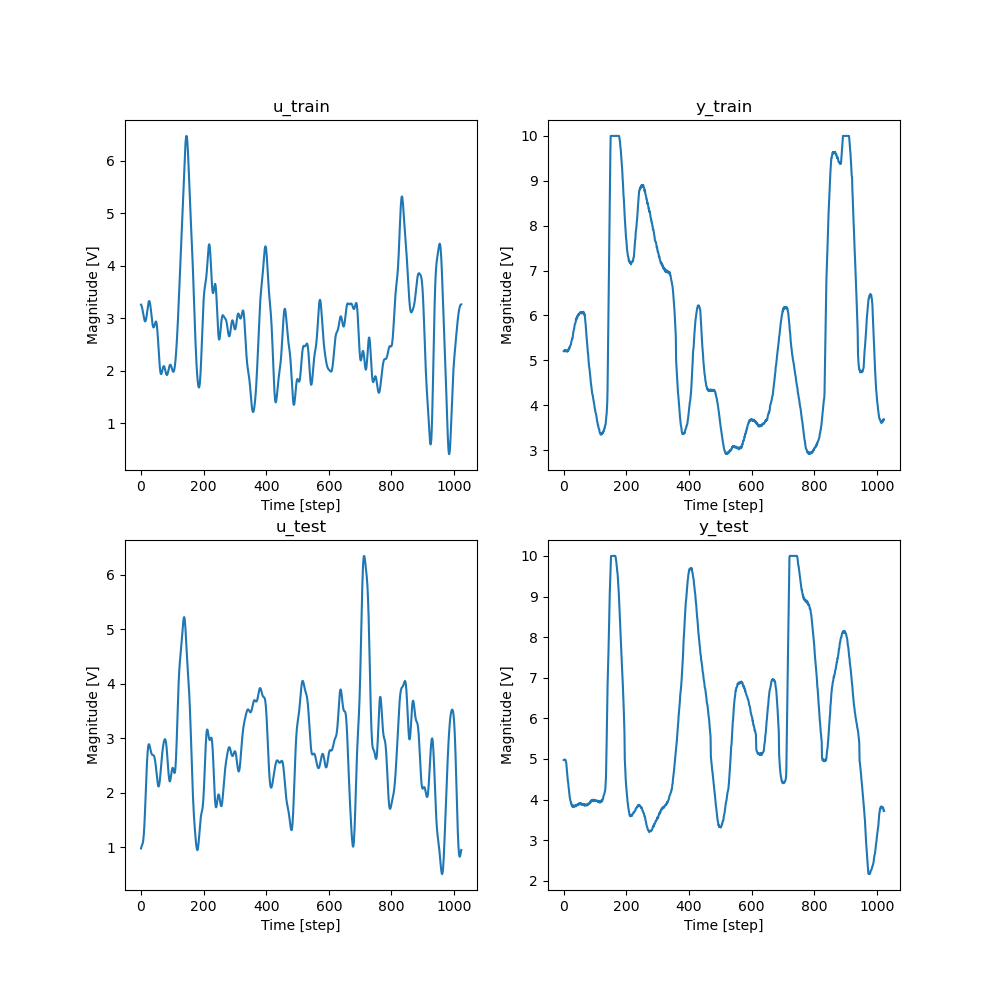

In [4]:
# plot input and output sequences

plt.figure(figsize = (10,10))
cols, rows = 2, 2

sequence_names = ('u_train', 'y_train', 'u_test', 'y_test')

for i, n in enumerate( sequence_names ):   
    plt.subplot(cols, rows, i + 1)
    plt.plot(dataset[n])
    plt.title(sequence_names[i])
    plt.xlabel('Time [step]')
    plt.ylabel('Magnitude [V]')

## Normalize data (good practice)

In [5]:
u_train = np.array(dataset['u_train'])
y_train = np.array(dataset['y_train'])

u_test = np.array(dataset['u_test'])
y_test = np.array(dataset['y_test'])


u_mean = np.mean(u_train); u_std = np.std(u_train) 
y_mean = np.mean(y_train); y_std = np.std(y_train)  

u_train = (u_train-u_mean)/u_std
u_test = (u_test-u_mean)/u_std

y_train = (y_train-y_mean)/y_std
y_test = (y_test-y_mean)/y_std

print(f"Training input: mean = {np.mean(u_train):.2f}; std = {np.std(u_train):.2f}")
print(f"Training output: mean = {np.mean(y_train):.2f}; std = {np.std(y_train):.2f}")

print(f"Test input: mean = {np.mean(u_test):.2f}; std = {np.std(u_test):.2f}")
print(f"Test output: mean = {np.mean(y_test):.2f}; std = {np.std(y_test):.2f}")

Training input: mean = 0.00; std = 1.00
Training output: mean = -0.00; std = 1.00
Test input: mean = 0.00; std = 1.00
Test output: mean = 0.07; std = 0.97


## Part 1: Linear regression

 ### Create regressor

In [6]:
# create regressor
na = 2 # output lag
nb = 2 # input lag
n = max((na,nb)) #number of initial conditions to consider

N_train = np.shape(y_train)[0] # number of samples
N_test = np.shape(y_test)[0] # number of samples

reg_train = np.zeros((N_train-n,na+nb+1))
reg_test = np.zeros((N_test-n,na+nb+1))

for idx in range(n, N_train):
    reg_train[idx-n, : ] = np.concatenate((np.flip(y_train[idx-na:idx]), np.flip(u_train[idx-nb:idx+1])))  
    
for idx in range(n, N_test): 
    reg_test[idx-n, : ] = np.concatenate((np.flip(y_test[idx-na:idx]), np.flip(u_test[idx-nb:idx+1])))

# The regressors are associated to the output from time n to time N-1 
y_train = np.reshape(y_train[n:],(-1,1))
y_test = np.reshape(y_test[n:],(-1,1))

# Least-squares estimate

In [7]:
thetaLS = np.linalg.solve( np.matmul(reg_train.transpose(),reg_train), np.matmul(reg_train.transpose(),y_train))
print(f"Least-square estimate: \n {thetaLS}")

Least-square estimate: 
 [[ 1.66078959]
 [-0.66568496]
 [ 0.06740859]
 [-0.17520155]
 [ 0.1192033 ]]


# Training using sklear

In [8]:
from sklearn.linear_model import LinearRegression

Lreg = LinearRegression(fit_intercept = False)
Lreg.fit(reg_train , y_train)


# comparison of theta coefficients with results of LS:
print(f"sklearn coefficients: \n {Lreg.coef_}")
print(f"Explicit Least squares coefficients: \n {thetaLS.transpose()}")

sklearn coefficients: 
 [[ 1.66078959 -0.66568496  0.06740859 -0.17520155  0.1192033 ]]
Explicit Least squares coefficients: 
 [[ 1.66078959 -0.66568496  0.06740859 -0.17520155  0.1192033 ]]


Training performance:
MSE: 0.0005; R2: 0.9995
Test performance:
MSE: 0.0006; R2: 0.9993


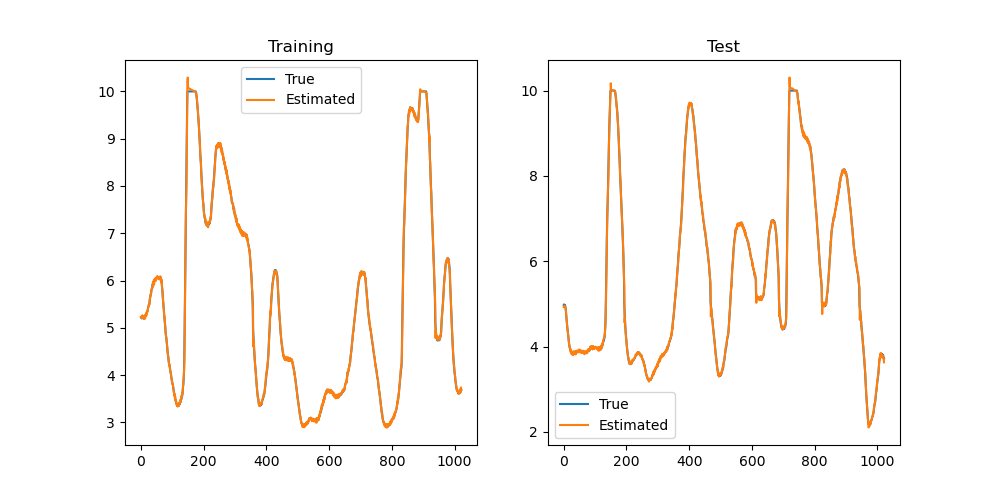

In [9]:
def compute_performance(Lreg, reg, y):
    coef = np.reshape(Lreg.coef_,(-1,1))
    
    err = np.matmul(reg, coef) - np.reshape(y,(-1,1))
    mse = np.mean(err**2)
    R2 = 1 - (mse/np.mean((y-np.mean(y))**2)) 
    return mse, R2, np.matmul(reg, coef)
    
mse_train, R2_train, y_hat_train = compute_performance(Lreg, reg_train, y_train)
print('Training performance:')
print(f"MSE: {mse_train:.4f}; R2: {R2_train:.4f}")

mse_test, R2_test, y_hat_test = compute_performance(Lreg, reg_test, y_test)
print('Test performance:')
print(f"MSE: {mse_test:.4f}; R2: {R2_test:.4f}")


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(y_train*y_std+y_mean, label = 'True')
plt.plot(y_hat_train*y_std+y_mean, label = 'Estimated')
plt.title('Training')
plt.legend()

plt.subplot(1,2,2)
plt.plot(y_test*y_std+y_mean, label = 'True')
plt.plot(y_hat_test*y_std+y_mean, label = 'Estimated')
plt.title('Test')
plt.legend()
plt.show()

### Question: Performance seems to be great! Do you think we obtained a good model?

# Testing open-loop simulation

Train - MSE: 0.0813, R2_test: 0.9188
Test - MSE: 0.0988, R2_test: 0.8951


/tmp/ipykernel_6909/1205084227.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_sim[idx] = np.matmul(x_reg_sim, theta)


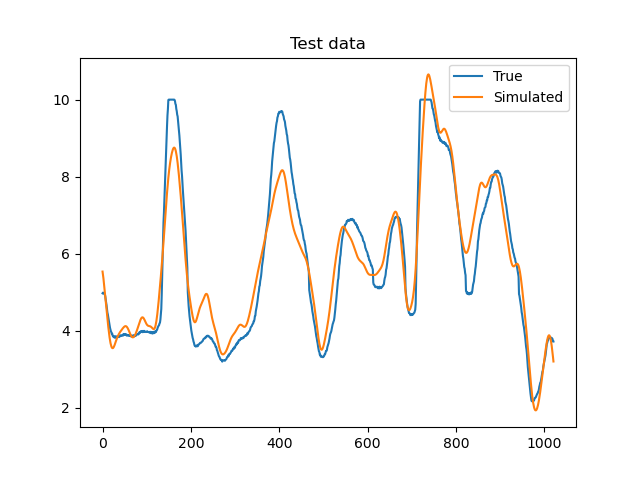

In [10]:
# simulatd performance

def simulate(theta, u_sim, na, nb, y0 = None):
    
    n = np.max((na, nb))
    N = u_sim.shape[0]
    y_sim = np.zeros(N)
    if y0 is not None:
        y_sim[0:n] = y0
        
    
    for idx in range(n, N):
        x_reg_sim = np.reshape(
            np.concatenate(
                (np.flip(y_sim[idx-na:idx]),
                 np.flip(u_sim[idx-nb:idx+1]))),
            (1,-1)) 
        y_sim[idx] = np.matmul(x_reg_sim, theta)
    
    return y_sim

def compute_sim_performance(y, y_hat):

    err =  np.reshape(y,(-1,1)) - np.reshape(y_hat,(-1,1))
    mse = np.mean(err**2)
    R2 = 1 - (mse/np.mean((y-np.mean(y))**2)) 
    return mse, R2


y_train_sim = simulate(thetaLS, u_train, na, nb)
mse_train, R2_train = compute_sim_performance(y_train, y_train_sim[n:] )
print(f"Train - MSE: {mse_train:.4f}, R2_test: {R2_train:.4f}")

    
y_test_sim = simulate(thetaLS, u_test, na, nb, y0 = np.array([0, 0]))
mse_test, R2_test = compute_sim_performance(y_test, y_test_sim[n:])
print(f"Test - MSE: {mse_test:.4f}, R2_test: {R2_test:.4f}")

plt.figure()
plt.plot(y_test*y_std+y_mean, label = 'True'),
plt.plot(y_test_sim[n:]*y_std+y_mean, label = 'Simulated')
plt.title('Test data')
plt.legend()
plt.show()

## End of first part

## Part 2: Simulation error minimization (pytorch-based solution)

In [11]:
# Simulation error minimization
    
def forward(theta, u_sim, na, nb, y):
    
    n = np.max((na, nb))
    N = u_sim.shape[0]
    y_sim = torch.zeros(N, dtype = torch.float32)
    y = torch.tensor(y, dtype = torch.float32)
    u_sim = torch.tensor(u_sim, dtype = torch.float32)
    
    for idx in range(n, N):
        x_reg_sim = torch.flip(y_sim[idx-na:idx], dims=[0]).unsqueeze(0)
        u_sim_flipped = torch.flip(u_sim[idx-nb:idx+1], dims=[0]).unsqueeze(0)
        x_reg_sim = torch.cat((x_reg_sim, u_sim_flipped), dim=1)
        
        y_sim[idx] = torch.matmul(x_reg_sim, theta)
    
    loss = torch.mean((y[:,0]-y_sim[n:])**2)
    
    return loss
    

#loss = forward(theta, u_train, na, nb, y_train)  
#print(loss)


In [12]:
import torch

reg_train_t = torch.tensor(reg_train, dtype = torch.float32)
y_train_t = torch.tensor(y_train, dtype = torch.float32)
theta = torch.tensor(thetaLS, dtype = torch.float32, requires_grad=True)

max_iter = 1000
lr = 1e-3

optimizer = torch.optim.Adam([theta], lr=lr)

for train_iter in range(max_iter):
    
    optimizer.zero_grad()
    
    # forward pass
    loss = forward(theta, u_train, na, nb, y_train) 

    # backward pass
    loss.backward()
    
    optimizer.step()
    
    if train_iter % 10 == 0:
        print(f"Iteration: {train_iter}, loss: {loss:2f}")

print(f"Estimated parameters: {theta}")

Iteration: 0, loss: 0.081306
Iteration: 10, loss: 0.079551
Iteration: 20, loss: 0.075462
Iteration: 30, loss: 0.074037
Iteration: 40, loss: 0.073532
Iteration: 50, loss: 0.073196
Iteration: 60, loss: 0.072907
Iteration: 70, loss: 0.072699
Iteration: 80, loss: 0.072530
Iteration: 90, loss: 0.072377
Iteration: 100, loss: 0.072249
Iteration: 110, loss: 0.072142
Iteration: 120, loss: 0.072054
Iteration: 130, loss: 0.071983
Iteration: 140, loss: 0.071927
Iteration: 150, loss: 0.071882
Iteration: 160, loss: 0.071847
Iteration: 170, loss: 0.071821
Iteration: 180, loss: 0.071801
Iteration: 190, loss: 0.071786
Iteration: 200, loss: 0.071774
Iteration: 210, loss: 0.071765
Iteration: 220, loss: 0.071757
Iteration: 230, loss: 0.071752
Iteration: 240, loss: 0.071747
Iteration: 250, loss: 0.071743
Iteration: 260, loss: 0.071740
Iteration: 270, loss: 0.071736
Iteration: 280, loss: 0.071734
Iteration: 290, loss: 0.071734
Iteration: 300, loss: 0.073795
Iteration: 310, loss: 0.072307
Iteration: 320, los

In [13]:
save_path = os.path.join('out', 'theta.pt')
torch.save(theta, save_path)
print(f"Theta saved to {save_path}")

Theta saved to out/theta.pt


MSE: 0.08539931064577676
R2: 0.9093171960149259


/tmp/ipykernel_6909/1205084227.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_sim[idx] = np.matmul(x_reg_sim, theta)


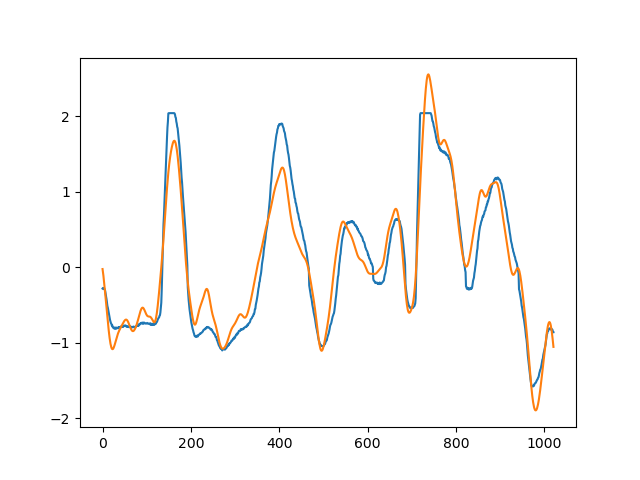

In [14]:
# Load the tensor from the file
file_path = os.path.join('out', 'theta.pt')
theta = torch.load(file_path)


y_test_sim = simulate(theta.detach().numpy(), u_test, na, nb, y0 = np.array([0, 0]))
mse_test, R2_test = compute_sim_performance(y_test, y_test_sim[n:])
print(f"MSE: {mse_test}")
print(f"R2: {R2_test}")


plt.figure()
plt.plot(y_test),
plt.plot(y_test_sim[n:])
plt.show()